In [1]:
import pickle
import json
import sys
import re
import os
import psutil
from functools import lru_cache
import time

from pathlib import Path
from tqdm import tqdm

from collections import Counter, OrderedDict, namedtuple
from functools import reduce

import pandas as pd
import numpy as np

import einops
from einops.layers.torch import Rearrange, Reduce

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.data import get_tokenizer
from torchtext.vocab import vocab

from random import randint
import random


from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

PROJECT_DIR = Path().absolute().parent
WIKI_PATH = PROJECT_DIR / 'InputData' / 'wikitext-103'
DATA_PATH = PROJECT_DIR / 'Data'

sys.path.append(str(PROJECT_DIR))

In [2]:
def process_memory():
    process = psutil.Process(os.getpid())
    print(f'{round(process.memory_info().rss * 10**(-6))} MB')

def objects_memory(*args):
    print(f'{round(sum([sys.getsizeof(obj) for obj in args]) * 10**(-6))} MB')

In [3]:
def save_pkl(obj, pth):
    with open(pth, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_pkl(pth):
    with open(pth, 'rb') as f:
        return pickle.load(f)

In [4]:
# from tokenizers import (
#     decoders,
#     models,
#     normalizers,
#     Regex,
#     pre_tokenizers,
#     processors,
#     trainers,
#     Tokenizer,
# )
from transformers import PreTrainedTokenizerFast

# Load Data

In [5]:
def load_data(tp='train'):
    if tp not in ['train', 'test', 'valid']:
        raise Exception('ERROR: Wrong type of data.')
    
    pth = WIKI_PATH / f'wiki.{tp}.raw'
    heading_pattern = '\n (= ){1,}[^=]*[^=] (= ){1,}\n \n'
    with open(pth, 'r') as f:
        raw_text = f.read()
    
    raw_text = re.split(heading_pattern, raw_text)
    raw_text = [x.strip().strip('\n').strip() for x in raw_text if x and x not in [' ', '= ']]
    return raw_text

In [6]:
%%time
train_data = load_data('train')
test_data = load_data('test')
valid_data = load_data('valid')

print(f'{len(train_data)}/{len(test_data)}/{len(valid_data)}')

271821/623/552
CPU times: user 4.89 s, sys: 4.02 s, total: 8.91 s
Wall time: 9.39 s


In [7]:
def get_training_corpus():
    for i in range(0, len(train_data), 1000):
        yield train_data[i : i + 1000]

# Build Alphabet

In [11]:
tmp_tokenizer = Tokenizer(models.Unigram())
tmp_tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.Replace("”", '"'),
        normalizers.Replace("“", '"'),
        normalizers.Replace('ˈ', "'"),
        normalizers.Replace('’',"'"),
        normalizers.Replace('–',"-"),
        normalizers.Replace('—',"-"),
        normalizers.Replace('−',"-"),
        normalizers.Replace('′',"'"),
        normalizers.Replace('⁄',"/"),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)
tmp_tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
    [
        pre_tokenizers.BertPreTokenizer(), 
        # pre_tokenizers.Metaspace(replacement = '_', add_prefix_space = True),
        # pre_tokenizers.Punctuation(),
        pre_tokenizers.Digits(individual_digits=True)
    ]
)

In [12]:
char_counter = Counter()
for i in tqdm(range(len(train_data))):
    art_counter = Counter(train_data[i])
    char_counter.update(art_counter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271821/271821 [00:26<00:00, 10429.47it/s]


In [13]:
char_counter_df = pd.DataFrame(char_counter.most_common(), columns=['Symbol', 'Count'])
char_counter_df.shape

(4978, 2)

In [14]:
def get_base_char(txt):
    tokens = tmp_tokenizer.encode(txt).tokens
    return tokens
char_counter_df['Base_Symbol'] = char_counter_df['Symbol'].apply(get_base_char)
char_counter_df['Base_Symbol'].apply(len).value_counts()

1    4735
0     229
3      11
2       2
4       1
Name: Base_Symbol, dtype: int64

In [15]:
char_counter_df[char_counter_df['Base_Symbol'].apply(len) > 1]

,Symbol,Count,Base_Symbol
122,…,1961,"[., ., .]"
172,½,757,"[1, ⁄, 2]"
202,″,535,"[′, ′]"
468,⅓,86,"[1, ⁄, 3]"
568,⅔,58,"[2, ⁄, 3]"
591,¼,55,"[1, ⁄, 4]"
592,¾,55,"[3, ⁄, 4]"
1310,⅜,11,"[3, ⁄, 8]"
1468,⅛,9,"[1, ⁄, 8]"
1482,⅝,9,"[5, ⁄, 8]"


In [16]:
char_counter_df['Single_Base_Symbol'] = char_counter_df['Base_Symbol'].apply(lambda x: x[0] if x else '')
char_counter_df

,Symbol,Count,Base_Symbol,Single_Base_Symbol
0,,99530965,[],
1,e,48657548,[e],e
2,t,33788437,[t],t
3,a,33364371,[a],a
4,n,28965321,[n],n
...,...,...,...,...
4973,課,1,[課],課
4974,純,1,[純],純
4975,丽,1,[丽],丽
4976,치,1,[치],치


In [17]:
char_counter_df = char_counter_df.groupby('Single_Base_Symbol')['Count'].sum().reset_index()
char_counter_df = char_counter_df.sort_values('Count', ascending=False).reset_index(drop=True)
char_counter_df

,Single_Base_Symbol,Count
0,,100128792
1,e,48715319
2,t,33789131
3,a,33401452
4,n,28970107
...,...,...
4195,恢,1
4196,恒,1
4197,恆,1
4198,怨,1


In [18]:
char_counter_df['Cum_Prc'] = (char_counter_df['Count'] / char_counter_df['Count'].sum()).cumsum()

In [19]:
char_counter_df.head(110).tail(60)

,Single_Base_Symbol,Count,Cum_Prc
50,),572467,0.984419
51,(,572111,0.985501
52,3,541764,0.986526
53,5,538413,0.987544
54,8,532060,0.988550
55,E,514159,0.989523
56,J,503445,0.990475
57,4,495231,0.991412
58,O,462139,0.992286
59,6,445885,0.993129


In [20]:
alphabet = list(char_counter_df['Single_Base_Symbol'][:90])
[x for x in range(10) if str(x) not in alphabet]

[]

# Build Tokenizer
https://colab.research.google.com/github/tenexcoder/huggingface-tutorials/blob/main/BERT_tokenizer_from_scratch.ipynb
https://huggingface.co/transformers/v3.5.1/main_classes/tokenizer.html
https://huggingface.co/course/chapter6/8?fw=tf

Steps
1) Normalization
2) Pre_tokenization
3) Model
4) Post-processor

## 1) Normalizer

In [21]:
normlzr = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.Replace("”", '"'),
        normalizers.Replace("“", '"'),
        normalizers.Replace('ˈ', "'"),
        normalizers.Replace('’',"'"),
        normalizers.Replace('–',"-"),
        normalizers.Replace('—',"-"),
        normalizers.Replace('−',"-"),
        normalizers.Replace('′',"'"),
        normalizers.Replace('⁄',"/"),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

## 2) Pre-tokenizer

In [22]:
pretknzr = pre_tokenizers.Sequence(
    [
        pre_tokenizers.BertPreTokenizer(), 
        # pre_tokenizers.Metaspace(replacement = '_', add_prefix_space = True),
        # pre_tokenizers.Punctuation(),
        pre_tokenizers.Digits(individual_digits=True)
    ]
)

## 3) Model Type

In [23]:
# ?trainers.BpeTrainer
# ?trainers.WordPieceTrainer

In [35]:
model_type = 'BPE'
# model_type = 'WordPiece'

SPEC_TOKENS = ["[MASK]", "[PAD]", "[UNK]",]

if model_type == 'WordPiece':
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    
    trainer = trainers.WordPieceTrainer(
        vocab_size=50000, 
        min_frequency=0, 
        special_tokens=SPEC_TOKENS, 
        limit_alphabet=len(alphabet),
        initial_alphabet=alphabet,
        continuing_subword_prefix='##',
        end_of_word_suffix='__'
        
    )
elif model_type == 'BPE':
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
    
    trainer = trainers.BpeTrainer(
        vocab_size=100000, 
        min_frequency=0, 
        special_tokens=SPEC_TOKENS, 
        limit_alphabet=len(alphabet),
        initial_alphabet=alphabet,
        continuing_subword_prefix='##',
        end_of_word_suffix='__'
    )
    
tokenizer.normalizer = normlzr
tokenizer.pre_tokenizer = pretknzr

In [36]:
tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.Replace("”", '"'),
        normalizers.Replace("“", '"'),
        normalizers.Replace('ˈ', "'"),
        normalizers.Replace('’',"'"),
        normalizers.Replace('–',"-"),
        normalizers.Replace('—',"-"),
        normalizers.Replace('−',"-"),
        normalizers.Replace('′',"'"),
        normalizers.Replace('⁄',"/"),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

## 4) Fit

In [37]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization! 123")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('pre', (11, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28)),
 ('1', (29, 30)),
 ('2', (30, 31)),
 ('3', (31, 32))]

In [38]:
%%time
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)




CPU times: user 9min 56s, sys: 31.6 s, total: 10min 28s
Wall time: 1min 1s


In [39]:
print(tokenizer.encode("Héllò hôw are ü?").tokens)

['Hello__', 'how__', 'are__', 'u__', '?__']


In [40]:
tokenizer.save(str(DATA_PATH / "Tokenizer_BPE100k.json"))

In [41]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(DATA_PATH / "Tokenizer_BPE100k.json"),
    unk_token="[UNK]",
    pad_token="[PAD]",
    mask_token="[MASK]"
)

# Post Tokenizer

In [44]:
def pre_post_tokenize(encoding):
    tokens = ['']
    tokens_ids = []
    for tk, tkid in zip(encoding.tokens, encoding.ids):
        if tk == '[UNK]' and tokens[-1] == '[UNK]':
            continue
        else:
            tokens.append(tk)
            tokens_ids.append(tkid)
        
    tokens.pop(0)
    
    return tokens, tokens_ids

In [45]:
tokenizer.token_to_id('[PAD]')

1

In [46]:
Token = namedtuple('Token', ['tid', 'value', 'title', 'upper','part', 'w_end'])

In [47]:
ALL_VOCAB = {
    'First': tokenizer.get_vocab(),
    'First_Reverse': {v:k for k,v in tokenizer.get_vocab().items()},
    'First_Second': {
        tokenizer.token_to_id('[MASK]'): Token(tid=tokenizer.token_to_id('[MASK]'), value='[mask]',
                       title=False, upper=False, part=False, w_end=True),
        tokenizer.token_to_id('[PAD]'): Token(tid=tokenizer.token_to_id('[PAD]'), value='[pad]',
                       title=False, upper=False, part=False, w_end=True),
        tokenizer.token_to_id('[UNK]'): Token(tid=tokenizer.token_to_id('[UNK]'), value='[unk]', 
                       title=False, upper=False, part=False, w_end=True),
        
    },
    'First_Second_Reverse': {
        Token(tid=tokenizer.token_to_id('[MASK]'), value='[mask]',
              title=False, upper=False, part=False, w_end=True): tokenizer.token_to_id('[MASK]'),
        Token(tid=tokenizer.token_to_id('[PAD]'), value='[pad]',
              title=False, upper=False, part=False, w_end=True): tokenizer.token_to_id('[PAD]'),
        Token(tid=tokenizer.token_to_id('[UNK]'), value='[unk]',
              title=False, upper=False, part=False, w_end=True): tokenizer.token_to_id('[UNK]'), 
        
    },
    'Second': {
        '[mask]': tokenizer.token_to_id('[MASK]'),
        '[pad]': tokenizer.token_to_id('[PAD]'),
        '[unk]': tokenizer.token_to_id('[UNK]'),
    },
    'Second_Reverse': {
        tokenizer.token_to_id('[MASK]'): '[mask]',
        tokenizer.token_to_id('[PAD]'): '[pad]',
        tokenizer.token_to_id('[UNK]'): '[unk]',
    }    
}

In [48]:
max_new_id = max(ALL_VOCAB['Second_Reverse'].keys())

for tk, tkid in tqdm(tokenizer.get_vocab().items()):
    if tkid in ALL_VOCAB['First_Second']:
        continue
        
    part = tk[:2] == '##'
    w_end = tk[-2:] == '__'
    tk = tk.replace('##','').replace('__','')
    upper = tk.isupper()
    title = tk[0].isupper()
    value = tk.lower()
    if value in ALL_VOCAB['Second'].keys():
        value_id = ALL_VOCAB['Second'][value]
    else:
        value_id = max(ALL_VOCAB['Second_Reverse'].keys()) + 1
        ALL_VOCAB['Second'][value] = value_id
        ALL_VOCAB['Second_Reverse'][value_id] = value
    
    tk = Token(
        tid=value_id, value=value, 
        title=title, upper=upper, part=part, w_end=w_end
    )
    ALL_VOCAB['First_Second'][tkid] = tk
    ALL_VOCAB['First_Second_Reverse'][tk] = tkid

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:55<00:00, 1789.18it/s]


In [49]:
len(ALL_VOCAB['Second_Reverse'])

75467

In [50]:
len(set(x.strip('__').strip('##').lower() for x in  tokenizer.get_vocab().keys()))

75467

In [51]:
save_pkl(ALL_VOCAB, DATA_PATH / "ALLVOCAB_BPE100k.pkl")

In [52]:
def encode_txt(txt, tokenizer, vocab):
    encoding = tokenizer.encode(txt)
    all_ids = [(fid, vocab['First_Second'][fid]) for fid in encoding.ids]
    return all_ids

In [53]:
encoding = tokenizer.encode(train_data[0])
print(encoding.tokens)
print(len(encoding.tokens))
# print(encoding.ids)

['Sen', '##jo__', 'no__', 'Valkyria__', '3__', ':__', 'Un', '##rec', '##orded__', 'Chronicles__', '(__', 'Japanese__', ':__', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '3__', ',__', 'lit__', '.__', 'Valkyria__', 'of__', 'the__', 'Battlefield__', '3__', ')__', ',__', 'commonly__', 'referred__', 'to__', 'as__', 'Valkyria__', 'Chronicles__', 'III__', 'outside__', 'Japan__', ',__', 'is__', 'a__', 'tactical__', 'role__', '@__', '-__', '@__', 'playing__', 'video__', 'game__', 'developed__', 'by__', 'Sega__', 'and__', 'Media__', '.__', 'Vision__', 'for__', 'the__', 'PlayStation__', 'Portable__', '.__', 'Released__', 'in__', 'January__', '2__', '0__', '1__', '1__', 'in__', 'Japan__', ',__', 'it__', 'is__', 'the__', 'third__', 'game__', 'in__', 'the__', 'Valkyria__', 'series__', '.__', 'Employing__', 'the__', 'same__', 'fusion__', 'of__', 'tactical__', 'and__', 'real__', '@__', '-__', '@__', 'time__', 'gameplay__', 'as__', 'its__', 'predecessors__

In [54]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if len(v.value) > 1 and v.upper])

2785

In [55]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if len(v.value) > 1 and v.title])

43760

In [56]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if v.part])

17737

In [57]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if v.w_end])

78507

In [58]:
len([(k,v) for k,v in ALL_VOCAB['First_Second'].items() if v.w_end and not v.part])

63573

In [59]:
len(ALL_VOCAB['First_Second'])

100000

# Make Train Data

In [11]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(DATA_PATH / "Tokenizer_BPE100k.json"),
    unk_token="[UNK]",
    pad_token="[PAD]",
    mask_token="[MASK]"
)

In [12]:
wrapped_tokenizer.unk_token_id

2

In [13]:
def merge_unks(toks, unk=0):
    return [tk for i, tk in enumerate(toks) if (tk != unk) or (i == 0) or (toks[i-1] != unk)]

In [14]:
def final_tokenizer(txt):
    tokens = wrapped_tokenizer(txt)['input_ids']
    tokens = merge_unks(tokens, wrapped_tokenizer.unk_token_id)
    return np.array(tokens)

In [15]:
def get_all_sub_seq(tokens, max_len, pad=1):
    ln = len(tokens)
    if ln < max_len:
        # print(f'Fact Length = {ln}')
        return np.array([np.concatenate([tokens, [pad]*(max_len - ln)])])
    sub_seqs = []
    for i in range(ln - max_len + 1):
        sub_seqs.append(tokens[i:i+max_len])
    return np.array(sub_seqs)

In [72]:
train_fixlen = [final_tokenizer(txt) for txt in train_data]

In [77]:
%%time
train_fixlen = [final_tokenizer(txt) for txt in train_data]
train_fixlen = [
    get_all_sub_seq(tks, max_len=1024, pad=wrapped_tokenizer.pad_token_id) 
    for tks in train_fixlen if len(tks) > 9
]
train_fixlen = np.concatenate(train_fixlen, axis=0)
train_fixlen = np.array(train_fixlen, np.uintc)
train_fixlen.shape #(103596449, 30)

CPU times: user 53.2 s, sys: 2min 18s, total: 3min 12s
Wall time: 4min 50s


(4272181, 1024)

In [ ]:
with open(DATA_PATH / 'train_1024T.npy', 'wb') as f:
    np.save(f, train_fixlen)

In [27]:
process_memory()
objects_memory(train_30T)

585 MB
24863 MB


# Load to Train

In [5]:
process_memory()

483 MB


In [8]:
with open(DATA_PATH / 'train_30T.npy', 'rb') as f:
    train_tokens = np.load(f)

In [10]:
1568715776 / 1024

1531949.0

In [94]:
Token = namedtuple('Token', ['tid', 'value', 'title', 'upper','part', 'w_end'])
ALL_VOCAB = load_pkl(DATA_PATH / "ALLVOCAB_BPE100k.pkl")

In [93]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(DATA_PATH / "Tokenizer_BPE100k.json"),
    unk_token="[UNK]",
    pad_token="[PAD]",
    mask_token="[MASK]"
)

In [78]:
process_memory()

1632 MB


In [79]:
objects_memory(train_tokens)

12432 MB


# Choose parameters

In [2]:
def show_step_size(vocab_size, enc_len, min_val=0, rnd=3):
    step = vocab_size**(1/enc_len)
    step = (1 if min_val == 0 else 2) / step
    print(f'Vocab size = {vocab_size}, Encodind length = {enc_len}, Diaposon = [{min_val},1]\t=>\tStep Size = {round(step,rnd)}')

In [12]:
ALL_VOCAB.keys()

dict_keys(['First', 'First_Reverse', 'First_Second', 'First_Second_Reverse', 'Second', 'Second_Reverse'])

In [13]:
len(ALL_VOCAB['Second'])

75463

In [81]:
show_step_size(len(ALL_VOCAB['Second']) + 1, 4, min_val=0)
show_step_size(len(ALL_VOCAB['Second']) + 1, 4, min_val=-1)
show_step_size(len(ALL_VOCAB['Second']) + 1, 5, min_val=0)
show_step_size(len(ALL_VOCAB['Second']) + 1, 5, min_val=-1)

Vocab size = 75464, Encodind length = 4, Diaposon = [0,1]	=>	Step Size = 0.06
Vocab size = 75464, Encodind length = 4, Diaposon = [-1,1]	=>	Step Size = 0.121
Vocab size = 75464, Encodind length = 5, Diaposon = [0,1]	=>	Step Size = 0.106
Vocab size = 75464, Encodind length = 5, Diaposon = [-1,1]	=>	Step Size = 0.212


In [54]:
# SEQUANCE LENGHT
show_step_size(1024, 3, min_val=-1)
show_step_size(1024, 3, min_val=0)
show_step_size(1024, 4, min_val=-1)
show_step_size(1024, 4, min_val=0)
show_step_size(1024, 5, min_val=-1)
show_step_size(1024, 5, min_val=0)
show_step_size(1024, 10, min_val=-1)


Vocab size = 1024, Encodind length = 3, Diaposon = [-1,1]	=>	Step Size = 0.198
Vocab size = 1024, Encodind length = 3, Diaposon = [0,1]	=>	Step Size = 0.099
Vocab size = 1024, Encodind length = 4, Diaposon = [-1,1]	=>	Step Size = 0.354
Vocab size = 1024, Encodind length = 4, Diaposon = [0,1]	=>	Step Size = 0.177
Vocab size = 1024, Encodind length = 5, Diaposon = [-1,1]	=>	Step Size = 0.5
Vocab size = 1024, Encodind length = 5, Diaposon = [0,1]	=>	Step Size = 0.25
Vocab size = 1024, Encodind length = 10, Diaposon = [-1,1]	=>	Step Size = 1.0


# Arhitecture

In [ ]:
# Input:
    # H_i = B x S x E_i
    # Conn_i = B x S x S x C

# Output: 
    # H_(i+1) = B x S x E_(i+1)
    # Conn_(i+1) = B x S x S x C

# Algo:
    # 1) H_i_ext_1 = B x S x S x e_i
    # 2) H_i_ext_2 = B x S x S x e_i
    # 3) Conn' = f1(H_i_ext_1, H_i_ext_2) = B x S x S x C
    # 4) Coef = f2(Conn', PosEnc) = B x S x S x 1
    # 5) Conn" = Coef * Conn'
    # 6) Conn_(i+1) = (1 - beta) * Conn_i + beta * Conn"
    
    # 7) Scores = f3(Conn_(i+1)), возможно несколько скоров и их голов эттеншена
    # 8) Att = f4(Scores)
    # 9) H_agg = Att * H_i
    # 10) H_(i+1) = f5(H_i, H_agg)

In [ ]:
# 1) Закончить логику с Эттеншн Блок
# 2) Инициализация сети











## TokensEncoding 

In [77]:
def gen_embed(vocab_size, dim=6, min_value=-1):
    cnt_per_item = int(np.ceil(vocab_size ** (1 / dim)))
    delta = 1 - min_value
    step_size = delta / cnt_per_item
    
    range_list = np.array([[min_value + i * step_size,] for i in range(cnt_per_item)])
    range_list[-1] = 1
    

    final_matrix = range_list
    for i in range(1,dim):
        ext_fm = einops.repeat(final_matrix, 'r c -> (rp r) c', rp=cnt_per_item)
        dop_col = einops.repeat(range_list, 'r c -> (r rp) c', rp=final_matrix.shape[0])
        final_matrix = np.concatenate([dop_col, ext_fm], axis=-1)
    return final_matrix

In [78]:
class TokensEncoding(nn.Module):

    def __init__(self, cnt_tokens, encoding_size, min_value=-1, seed=0):
        super(TokensEncoding, self).__init__()
        self.cnt_tokens = cnt_tokens
        self.encoding_size = encoding_size
        self.min_value = min_value
        
        # Encoding Matrix
        self.tokens_encoding = nn.Embedding(self.cnt_tokens, self.encoding_size)
        self.init_weights(seed)

    def init_weights(self, seed):
        np.random.seed(seed)
        full_matrix = gen_embed(self.cnt_tokens, self.encoding_size, self.min_value)
        np.random.shuffle(full_matrix)
        self.tokens_encoding.weight.data = torch.tensor(full_matrix[:self.cnt_tokens], dtype=torch.float32).\
            requires_grad_(False)

    def forward(self, batch, ptime=False):
        # batch = batch x seq_len
        t0 = time.time()
        
        tokens_encoding = self.tokens_encoding(batch)
        if ptime:
            print(f'TokensEncoding, forward time: {time.time()-t0}')
            
        # tokens_encoding = batch x seq_len x encoding_size
        return tokens_encoding
    
    
    def init_optims(self, opt_type, lr):
        pass
    
    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        pass
        
    def zero_grad(self):
        pass

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## FFNet

In [79]:
class FFNet(nn.Module):

    def __init__(self, input_size, output_size, activation=torch.tanh, seed=0):
        super(FFNet, self).__init__()
        self.seed=seed
        self.input_size = input_size
        self.output_size = output_size
        self.lay0 = nn.Linear(in_features=input_size, out_features=output_size)
        self.activation = activation
        self.init_weights(seed)
        
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        # nn.init.xavier_uniform_(self.lay0.weight, gain=1.0)
        nn.init.xavier_uniform_(self.lay0.weight)
        nn.init.constant_(self.lay0.bias, 0)
        # self.lay0.weight.data = torch.tensor(np.array(self.lay0.weight.data), dtype=torch.float32).requires_grad_(True)
        # self.lay0.bias.data = torch.tensor(np.array(self.lay0.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward(self, batch, ptime=False):
        # batch = b x s x (h + sum(agg_h))
        t0 = time.time()
        
        batch = self.activation(self.lay0(batch))
        # batch = b x s x h_new
        
        if ptime:
            print(f'FFNet, forward time: {time.time()-t0}')
        return batch

    def init_optims(self, opt_type, lr):
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## ConnectionCoef (Conv)

In [80]:
class ConnectionCoefConv(nn.Module):

    def __init__(self, max_seq_len, seed=0):
        super(ConnectionCoefConv, self).__init__()
        self.seed = seed
        self.windows = [4,8,16,32,64]
        
        for w in self.windows:
            setattr(self, f'window_lay_{w}', 
                    torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(w,2), stride=w, padding=0)
                   )
        
        self.pos_input = torch.tensor(
            np.log(1 + np.array([[abs(i - j) for j in range(max_seq_len)] for i in range(max_seq_len)])) / np.log(max_seq_len),
            dtype=torch.float32
        ).requires_grad_(False)
        # pos_input = S x S
        
        
        self.agg_lay = nn.Linear(in_features=2 + len(self.windows), out_features=1)
        self.init_weights(seed)
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        # TODO: Инициализация
        pass
        
    def forward(self, coefs, ptime=False):
        # batch = b x s x s x 1
        t0 = time.time()
        
        b = coefs.shape[0]
        s = coefs.shape[1]
        
        ost = coefs.shape[1] % self.windows[-1]
        
        if ost:
            dop = self.windows[-1] - ost
            dop = torch.zeros((b, s, dop, 1), dtype=torch.float32).requires_grad_(False)
            coefs = torch.cat([coefs, dop], axis=2)
        
        s2 = coefs.shape[2]
        pos_input = self.pos_input[:s,:s2]
        # pos_input = s x s
        pos_input = einops.repeat(pos_input, 's1 s2 -> b s1 s2 l', b=b, l=1)
        
        coefs = torch.cat([coefs, pos_input], axis=3)
        coefs = einops.rearrange(coefs, 'b s1 s2 l -> (b s1) s2 l')
        
        agg_windows = [coefs, ]
        usq_coefs = coefs.unsqueeze(1)
        for w in self.windows:
            tmp_agg = getattr(self, f'window_lay_{w}')(usq_coefs)
            # tmp_agg = (b * s1) x 2 x r x 1
            tmp_agg = einops.repeat(tmp_agg, 'bs c k v -> bs (k w) (c v)', w=w)
            # tmp_agg = (b * s1) x s2 x 2
            agg_windows.append(tmp_agg)
        
        agg_windows = torch.cat(agg_windows, axis=-1)
        # agg_windows = (b * s1) x s2 x (cnt_windows + 1) * 2
        
        coefs = torch.sigmoid(self.agg_lay(agg_windows))
        # coefs = (b * s1) x s2 x 1
        coefs = einops.rearrange(coefs, '(b s1) s2 l -> b s1 s2 l', b=b, s1=s)
        # coefs = b x s1 x s2 x 1
        coefs = coefs[:,:,:s,:]
        # coefs = b x s x s x 1
        
        if ptime:
            print(f'ConnectionCoefConv, forward time: {time.time()-t0}')
        return coefs

    def init_optims(self, opt_type, lr):
        self.current_weight_lr = lr
        self.opt = getattr(optim, opt_type)([self.lay0.weight, self.lay0.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## ConnectionCoef (Pooling)

In [81]:
class ConnectionCoefPool(nn.Module):

    def __init__(self, max_seq_len, seed=0):
        super(ConnectionCoefPool, self).__init__()
        self.seed = seed
        self.windows = [5,9,17,33,65]
        
        for w in self.windows:
            setattr(self, f'window_{w}_max', 
                    torch.nn.MaxPool1d(kernel_size=w, stride=1, padding=int((w - 1) / 2))
                   )
            setattr(self, f'window_{w}_avg', 
                    torch.nn.AvgPool1d(kernel_size=w, stride=1, padding=int((w - 1) / 2))
                   )
        
        self.agg_lay = nn.Linear(in_features=3 * len(self.windows) + 2, out_features=1)
        self.init_weights(seed)
    
    def init_weights(self, seed):
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.agg_lay.weight, gain=1.0)
        nn.init.constant_(self.agg_lay.bias, 0)
        # self.agg_lay.weight.data = torch.tensor(np.array(self.agg_lay.weight.data), dtype=torch.float32).requires_grad_(True)
        # self.agg_lay.bias.data = torch.tensor(np.array(self.agg_lay.bias.data), dtype=torch.float32).requires_grad_(True)
        
        
    def forward(self, coefs, ptime=False):
        # batch = b x s x s x 1
        t0 = time.time()
        
        b = coefs.shape[0]
        s = coefs.shape[1]
        
        sq_coefs = coefs.squeeze(-1)
        ones_coefs = torch.ones_like(sq_coefs, dtype=torch.float32).requires_grad_(False)
        
        pos_input = POSITION_MATRIX[:s,:s]
        # pos_input = s x s
        pos_input = einops.repeat(pos_input, 's1 s2 -> b s1 s2 l', b=b, l=1)
        # pos_input = b x s x s x 1
        
        coefs = torch.cat([coefs, pos_input], axis=3)
        
        agg_windows = [coefs, ]
        
        for w in self.windows:
            max_coef = getattr(self, f'window_{w}_max')(sq_coefs).unsqueeze(-1)
            # max_coef = b * s x s x 1
            agg_windows.append(max_coef)
                    
            avg_coef = getattr(self, f'window_{w}_avg')(sq_coefs).unsqueeze(-1)
            # avg_coef = b * s x s x 1
            agg_windows.append(avg_coef)
            
            prc_coef = getattr(self, f'window_{w}_avg')(ones_coefs).unsqueeze(-1)
            agg_windows.append(prc_coef)
        
        agg_windows = torch.cat(agg_windows, axis=-1)
        # agg_windows = b x s x s x cnt_windows * 2 + 2
        
        coefs = torch.sigmoid(self.agg_lay(agg_windows))
        # coefs = b x s x s x 1
        if ptime:
            print(f'ConnectionCoefPool, forward time: {time.time()-t0}')
        return coefs

    def init_optims(self, opt_type, lr):
        self.opt = getattr(optim, opt_type)([self.agg_lay.weight, self.agg_lay.bias], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

In [82]:
ConnectionCoef = ConnectionCoefPool

## AttentionBlock

In [128]:
class AttentionBlock(nn.Module):

    def __init__(self, max_seq_len, conn_size, seed=0):
        super(AttentionBlock, self).__init__()
        self.score_net = FFNet(conn_size, 1, activation=torch.tanh, seed=seed)
        self.agg_net = ConnectionCoef(max_seq_len=max_seq_len, seed=seed+1)
        self.softmax = nn.Softmax(dim=-1)
        self.mask = torch.ones((max_seq_len, max_seq_len), dtype=torch.float32).requires_grad_(False)
        self.mask = (self.mask - torch.diag(torch.tensor([1]*max_seq_len))).requires_grad_(False)
    
    def forward(self, h_ext_w, conn, pad_mask, ptime=False):
        # h_ext_w = b x s x s x h
        # conn = b x s x s x c
        t0 = time.time()
        b, s, _, _ = conn.shape
        
        
        self_mask = einops.repeat(self.mask[:s,:s].unsqueeze(-1), 's1 s2 v -> b s1 s2 v', b=b)
        # self_mask = b x s x s x 1
        
        full_mask = (pad_mask * self_mask).requires_grad_(False)
        scores = self.score_net.forward(conn)
        scores = full_mask * scores
        # scores = b x s x s x 1
        
        att = self.agg_net.forward(scores) * 5
        att = full_mask * att
        # att = b x s x s x 1
        
        att = self.softmax(att.squeeze(-1)).unsqueeze(-1)
        # att = b x s x s x 1
        
        h_agg = (h_ext_w * att).sum(axis=2)
        # h_agg = b x s x h
        
        if ptime:
            print(f'AttentionBlock, forward time: {time.time()-t0}')
        return h_agg
    
    def init_optims(self, opt_type, lr):
        self.score_net.init_optims(opt_type, lr)
        self.agg_net.init_optims(opt_type, lr)
        
    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.score_net.step()
        self.agg_net.step()

    def zero_grad(self):
        self.score_net.zero_grad()
        self.agg_net.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## GeneralBlock

In [129]:
class GeneralBlock(nn.Module):

    def __init__(self, input_size, output_size, conn_size, max_seq_len, cnt_attentions=1, lvl=0, seed=0):
        super(GeneralBlock, self).__init__()
        self.lvl = lvl
        self.cnt_attentions = cnt_attentions
        self.input_size = input_size
        self.output_size = output_size
        self.conn_size = conn_size
        
        self.conn_net = FFNet(2 * input_size, conn_size, activation=torch.tanh, seed=100*lvl + seed)
        self.conn_coefs = FFNet(2 * input_size, 1, activation=torch.sigmoid, seed=100*lvl+ 10 + seed)
        self.agg_conn_coefs = ConnectionCoef(max_seq_len=max_seq_len, seed=100*lvl+seed)
        
        self.att_blocks = [
            AttentionBlock(max_seq_len=max_seq_len, conn_size=conn_size, seed=100*lvl + 10*i + seed) 
            for i in range(1, self.cnt_attentions + 1)
        ]
        self.process_hidden = FFNet(input_size*(cnt_attentions + 1), output_size, activation=torch.tanh, seed=100*lvl + 20 + seed)
    
    def forward(self, h, conn, pad_mask, beta, ptime=False):
        # h = b x s x h
        # conn = b x s x s x c
        # pad_mask = b x s x s x 1
        
        t0 = time.time()
        h_ext_w = einops.repeat(h, 'b s1 h -> b s2 s1 h', s2=h.shape[1])
        h_ext_h = einops.repeat(h, 'b s1 h -> b s1 s2 h', s2=h.shape[1])
        

        
        hh = torch.cat([h_ext_h, h_ext_w], axis=-1)
        conn_tmp = self.conn_net.forward(hh)
        conn_tmp = conn_tmp * pad_mask
        
        # conn_tmp = b x s x s x c
        coef = self.conn_coefs.forward(hh, ptime=False)
        coef = coef * pad_mask
        # coef = b x s x s x 1
        
        coef = self.agg_conn_coefs.forward(coef, ptime=False)
        # coef = coef * pad_mask - Лишнее
        # coef = b x s x s x 1
        
        conn_tmp = conn_tmp * coef
        # conn_tmp = b x s x s x c
        
        # Transpose matrix
        conn_tmp2 = einops.rearrange(conn_tmp, 'b s1 s2 c -> b s2 s1 c')
        conn_tmp = (conn_tmp + conn_tmp2) / 2
        
        
        if beta == 1 or self.lvl == 0:
            conn = conn_tmp
        else:
            conn = (1 - beta) * conn + beta * conn_tmp
        # conn = b x s x s x c
        
        agg_h = [h,]
        for i in range(self.cnt_attentions):
            agg_h.append(self.att_blocks[i].forward(h_ext_w, conn, pad_mask, ptime=False))
            # h_agg = b x s x h
        h = self.process_hidden.forward(torch.cat(agg_h, axis=-1), ptime=False)
        # h = b x s x h_new
        
        if ptime:
            print(f'GeneralBlock, forward time: {time.time()-t0}')
        
        return h, conn
    
    def init_optims(self, opt_type, lr):
        self.conn_net.init_optims(opt_type, lr)
        self.conn_coefs.init_optims(opt_type, lr)
        self.agg_conn_coefs.init_optims(opt_type, lr)
        self.process_hidden.init_optims(opt_type, lr)
        
        for att in self.att_blocks:
            att.init_optims(opt_type, lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.conn_net.step()
        self.conn_coefs.step()
        self.agg_conn_coefs.step()
        self.process_hidden.step()
        
        for att in self.att_blocks:
            att.step()

    def zero_grad(self):
        self.conn_net.zero_grad()
        self.conn_coefs.zero_grad()
        self.agg_conn_coefs.zero_grad()
        self.process_hidden.zero_grad()
        
        for att in self.att_blocks:
            att.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Multi Blocks

In [258]:
class MultiBlocks(nn.Module):

    def __init__(self, sizes, conn_size, max_seq_len, cnt_attentions=1, seed=0):
        super(MultiBlocks, self).__init__()
        self.sizes = sizes
        self.conn_size = conn_size
        self.max_seq_len = max_seq_len
        self.cnt_attentions = cnt_attentions
        self.seed = seed
        
        
        self.general_blocks = [
            GeneralBlock(
                input_size=inp_sz, 
                output_size=self.sizes[lvl+1], 
                conn_size=conn_size, 
                max_seq_len=max_seq_len, 
                cnt_attentions=cnt_attentions, 
                lvl=lvl, seed=seed
            ) 
            for lvl, inp_sz in enumerate(self.sizes[:-1])
        ]
        
    def forward(self, h, conn, pad_mask, beta, ptime=False):
        # h = b x s x h
        # conn = b x s x s x c
        
        t0 = time.time()
        
        new_hidden = []
        for block in self.general_blocks:
            h, conn = block.forward(h, conn, pad_mask, beta, ptime=False)
            new_hidden.append(h)
        
        if ptime:
            print(f'MultiBlock, forward time: {time.time()-t0}')
        return new_hidden, conn

    def add_gblock(self, output_size):
        self.general_blocks.append(
            GeneralBlock(
                input_size=self.sizes[-1], 
                output_size=output_size, 
                conn_size=self.conn_size, 
                max_seq_len=self.max_seq_len, 
                cnt_attentions=self.cnt_attentions, 
                lvl=len(self.sizes), seed=seed
            )
        )
        self.sizes.append(output_size)
        
    def init_optims(self, opt_type, lr):
        for gblock in self.general_blocks:
            gblock.init_optims(opt_type, lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        for gblock in self.general_blocks:
            gblock.step()
        
    def zero_grad(self):
        for gblock in self.general_blocks:
            gblock.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

## Tokens Embeding (No categories)

In [131]:
class TokensEmbeding(nn.Module):

    def __init__(self, cnt_tokens, cnt_meanings, meaning_embeding, seed=0):
        super(TokensEmbeding, self).__init__()
        self.cnt_tokens = cnt_tokens
        self.cnt_meanings = cnt_meanings
        self.meaning_embeding = meaning_embeding
        
        self.token_embedings = nn.Embedding(self.cnt_tokens, self.cnt_meanings * self.meaning_embeding)
        
    def init_weights(self, seed):
        torch.manual_seed(seed)
        torch.manual_seed(3)
        self.token_embedings.weight.data.uniform_(-1, 1)
        

    def forward(self, batch, ptime=False):
        # batch = batch x seq_len x 1+negative x 1     
        t0 = time.time()
        b, s, _ = batch.shape
        
        batch = self.token_embedings(batch)
        # batch = batch x seq_len x (1+negative) x (cnt_meanings * emb)

        batch = einops.rearrange(batch, 'b s c (m e) -> b s (c m) e', m=self.cnt_meanings, e=self.meaning_embeding)
        # batch = batch x seq_len x ((1+negative) * cnt_meanings) x emb
        
        if ptime:
            print(f'TokensEmbeding, forward time: {time.time()-t0}')
        return batch
    
    
    def init_optims(self, opt_type, lr):
        self.opt = getattr(optim, opt_type)([self.token_embedings.weight], lr=lr)

    def set_lr(self, lr_weight, lr_bias):
        pass

    def step(self):
        self.opt.step()
        
    def zero_grad(self):
        self.opt.zero_grad()

    def clip_grad(self, maxg=1e-2):
        pass

    def count_params(self):
        return 0

# Train

## Utils Functions

In [132]:
# @lru_cache(maxsize=1000)
def change_tokens(tkid):
    new_tk = ALL_VOCAB['First_Second'][tkid]
    # return new_tk.tid
    return (new_tk.tid, int(new_tk.title), int(new_tk.upper), int(new_tk.part), int(new_tk.w_end))

v_change_tokens = np.vectorize(change_tokens)

def preprocess_batch(batch):
    return np.stack(v_change_tokens(batch), axis=2)


def reorder_posistions(matrix, wpos):
    sz, _ = matrix.shape
    indx = [wpos,] + [i for i in range(sz) if i != wpos]
    return matrix[indx,:][:,indx]

def reorder_tokens(marix, w0):
    matrix = np.array([
        marix[i,[w0[i],] + [j for j in range(marix.shape[1]) if j != w0[i]]] 
        for i in range(marix.shape[0])
    ])
    return matrix

def negative_tokens(tkid, cnt, with_positive=False):
    neg_set = set()
    if with_positive:
        cnt += 1
        
    while len(neg_set) != cnt:
        tmp_set = set(np.random.randint(0, high=len(ALL_VOCAB['Second']), size=cnt - len(neg_set), dtype=int))
        if not with_positive:
            tmp_set = tmp_set - {tkid}
        neg_set = neg_set | tmp_set
    return tuple(neg_set)

v_negative_tokens = np.vectorize(negative_tokens)

In [133]:
def init_optims(nets, opt_type, lr):
    for net in nets:
        if type(net) is list:
            for subnet in net:
                subnet.init_optims(opt_type, lr)
        else:
            net.init_optims(opt_type, lr)
            
def zero_grad(nets):
    for net in nets:
        if type(net) is list:
            for subnet in net:
                subnet.zero_grad()
        else:
            net.zero_grad()
            
def step_grad(nets):
    for net in nets:
        if type(net) is list:
            for subnet in net:
                subnet.step()
        else:
            net.step()

## Parameters

In [259]:
MAX_SEQ_LEN = 1024
TOKEN_ENCODING_SIZE = 4
CNT_PROPS = 4
TOKEN_ENCODING_MIN_VALUE = -1
PAD_ID = wrapped_tokenizer.pad_token_id
MASK_ID = 0

HIDDEN_SIZES = [8, 16, 32] # , 64, 128]
CONN_SIZE = 20
CNT_ATTANTIONS = 5

CNT_MEANINGS = 10
MEANINGS_SIZE = 64

BETA = 0.8
CNT_NEGATIVE = 5
LAST_PREDICT = 1
LOSS_COEFF = [1,]

LOSS_PROPERTY_COEFF = 0.2
LOSS_NEGATIVE_COEF = 0.1
LOSS_MAX_COEF = 1
LOSS_SUM_COEF = 0.01
NOT_MASKED_COEF = 0.5

POSITION_MATRIX = np.array([[(-1 if i > j else 1) * np.log(1 + abs(j-i)) for j in range(MAX_SEQ_LEN)] for i in range(MAX_SEQ_LEN)])
POSITION_MATRIX = POSITION_MATRIX / np.log(MAX_SEQ_LEN)
POSITION_MATRIX = torch.tensor(POSITION_MATRIX, dtype=torch.float32).requires_grad_(False)

## Define Nets

In [260]:
net_token_enc = TokensEncoding(
    cnt_tokens=len(ALL_VOCAB['Second']) + 1, 
    encoding_size=TOKEN_ENCODING_SIZE, 
    min_value=TOKEN_ENCODING_MIN_VALUE, 
    seed=0
)
net_multi_blocks = MultiBlocks(
    sizes=HIDDEN_SIZES, 
    conn_size=CONN_SIZE, 
    max_seq_len=MAX_SEQ_LEN, 
    cnt_attentions=CNT_ATTANTIONS, 
    seed=0
)

token_embeding_net = TokensEmbeding(
    len(ALL_VOCAB['Second']), 
    cnt_meanings=CNT_MEANINGS, 
    meaning_embeding=MEANINGS_SIZE, 
    seed=0
)

meaning_pred_net = FFNet(input_size=HIDDEN_SIZES[-1] + MEANINGS_SIZE, output_size=1, activation=torch.sigmoid, seed=0) 
props_pred_net = FFNet(input_size=HIDDEN_SIZES[-1], output_size=CNT_PROPS, activation=torch.sigmoid, seed=0) 

## Train Function

In [261]:
def step_1(batch, pad, mask, max_len):
    # Prepare Batch
    batch_size = batch.shape[0]
    batch_len = batch.shape[1] - (batch == pad).sum(axis=1) # Определеям длины последовательностей в батче, (Batch,)
    seq_len = max(batch_len)
    
    max_len = min(seq_len, max_len)
    min_len = 10
    choosen_len = random.choice(range(min_len, max_len + 1))
    indx = [0 if ln <= choosen_len else random.choice(range(ln - choosen_len + 1)) for ln in batch_len]
    batch = [batch[i, pos:pos+choosen_len] for i,pos in enumerate(indx)]
    batch = np.stack(batch, axis=0)
    batch_len = np.where(batch_len < choosen_len, batch_len, choosen_len)
    
    # if seq_len < batch.shape[1]:
    #     batch = batch[:, :seq_len] # Если максимальная длина меньше дефолтной, ограничиваем массив
    
    # Делаем замену начальных токенов на новые токены + фичи + Негативный сэмплинг
    batch = preprocess_batch(batch)
    
    true_tokens = torch.tensor(batch[:,:,0], dtype=torch.int).requires_grad_(False) 
    true_properties = torch.tensor(batch[:,:,1:], dtype=torch.float32).requires_grad_(False)
    
    masked_tokens = batch[:,:,0]
    masked_positions = [random.randint(0, x-1) for x in batch_len]
    masked_tokens[range(batch_size), masked_positions] = mask
    masked_tokens = torch.tensor(masked_tokens, dtype=torch.int).requires_grad_(False) 
    
    masked_properties = batch[:,:,1:]
    masked_properties[range(batch_size), masked_positions, :] = 0
    masked_properties = torch.tensor(masked_properties, dtype=torch.float32).requires_grad_(False)
    
    pad_mask_1 = torch.tensor(
        [[1,] * x + [0,] * (choosen_len - x) for x in list(batch_len)], 
        dtype=torch.float32
    ).unsqueeze(-1).requires_grad_(False)
    
    pad_mask_2 = [
        [
            [1 if (i < batch_len[b] and j < batch_len[b]) else 0 for j in range(choosen_len)]
            for i in range(choosen_len)
        ] for b in range(batch_size)
    ]
    pad_mask_2 = torch.tensor(pad_mask_2, dtype=torch.float32).unsqueeze(-1).requires_grad_(False)
    return (batch_size, batch_len, seq_len, pad_mask_1, pad_mask_2, true_tokens, true_properties, 
            masked_positions, masked_tokens, masked_properties)

def step_2(tokens, properties, token_enc_net, main_net, beta, seq_len, pad_mask):
    # Forward batch
    batch_size = tokens.shape[0]
    
    tk_enc = token_enc_net.forward(tokens)
    # tk_enc = batch x seq_len x enc
    
    tk_enc = torch.cat([tk_enc, properties], axis=-1)
    # tk_enc = batch x seq_len x enc + props
    
    conn_matrix = torch.zeros((batch_size, seq_len, seq_len, main_net.conn_size)).requires_grad_(False).type(torch.float32)
    list_tk_enc, conn_matrix = main_net.forward(tk_enc, conn_matrix, pad_mask, beta, ptime=False)
    
    return list_tk_enc, conn_matrix


def step3(batch, token_emb_net, cnt_negative):
    # Embeding tokens + Negative
    if cnt_negative != 0:
        negative_batch = torch.tensor(
            np.stack(v_negative_tokens(batch, cnt_negative, True), axis=2), 
            dtype=torch.int
        ).requires_grad_(False)
    else:
        negative_batch = batch.unsqueeze(2)
    # negative_batch = b x s x (1 + cnt_negative) x 1
    
    negative_batch = token_emb_net.forward(negative_batch)
    # negative_batch = b x s x ((1 + cnt_negative) * cnt_meanings) x emb
    return negative_batch
    
def step4(pred_tokens_encoding, fact_token_embeding, meaning_pred_net, props_pred_net, last_pred=1):
    # pred_tokens_encoding (list) = rounds x b x s x h
    # fact_token_embeding = b x s x ((1+cnt_negative)*cnt_meanings) x emb
    scores = []
    props = []
    for i in range(1, 10000):
        h = einops.repeat(pred_tokens_encoding[-i], 'b s h -> b s rp h', rp = fact_token_embeding.shape[2])
        round_scores = meaning_pred_net.forward(torch.cat([h,fact_token_embeding], axis=-1)).squeeze()
        scores.append(round_scores)
        
        props_pred = props_pred_net.forward(pred_tokens_encoding[-i])
        props.append(props_pred)
        if i == last_pred:
            break
    return scores[::-1], props[::-1]

def step5(scores, pred_props, fact_props, cnt_negative, cnt_meanings, loss_coeff, pad_mask, masked_positions,
          prop_coef, negative_coef, max_coef, sum_coef, not_masked_coef):
    bce_none_loss = torch.nn.BCELoss(reduction='none')
    l2_none_loss = torch.nn.MSELoss(reduction='none')
    
    # Loss Calculation
    if len(scores) == 1:
        scores = scores[0].unsqueeze(0)
    else:
        scores = einops.rearrange(scores,'r b s v -> r b s v')
        
    if len(pred_props) == 1:
        pred_props = pred_props[0].unsqueeze(0)
    else:
        pred_props = einops.rearrange(pred_props,'r b s v -> r b s v')
    
    r, b, s, v = scores.shape
    _, _, p = fact_props.shape
    
    loss_coeff = torch.tensor(loss_coeff, dtype=torch.float32).requires_grad_(False)
    loss_coeff = einops.repeat(loss_coeff,'r -> r b s v', b=b, s=s, v=1)
    pad_mask_ext = einops.repeat(pad_mask,'b s v -> r b s v', r=r).requires_grad_(False)
    # pad_mask_ext = rounds_agg x batch x seq_len x 1
    
    masked_mask = torch.full((b, s, 1), not_masked_coef, dtype=torch.float32).requires_grad_(False)
    masked_mask[range(b), masked_positions, 0] = 1
    masked_mask = einops.repeat(masked_mask,'b s v -> r b s v', r=r).requires_grad_(False)
    
    fact_props = einops.repeat(fact_props,'b s p -> r b s p', r=r).requires_grad_(False)
    # fact_props = rounds_agg x batch x seq_len x cnt_props
    
    loss_props = bce_none_loss(pred_props, fact_props)
    # loss_props = rounds_agg x batch x seq_len x cnt_props
    
    loss_props_mask = loss_props * loss_coeff * pad_mask_ext * masked_mask
    # loss_props_mask = rounds_agg x batch x seq_len x cnt_props
    
    true_part = scores[:,:,:,:cnt_meanings]
    neg_part = scores[:,:,:,cnt_meanings:]
    _, _, _, cnt_negs = neg_part.shape
    fact_neg = torch.zeros_like(neg_part, dtype=torch.float32).requires_grad_(False)

    loss_negs = bce_none_loss(neg_part, fact_neg)
    # loss_negs = rounds_agg x batch x seq_len x (cnt_negative * cnt_meanings)
    
    loss_negs_mask = loss_negs * loss_coeff * pad_mask_ext * masked_mask
    # loss_negs_mask = rounds_agg x batch x seq_len x (cnt_negative * cnt_meanings)

    max_pred = true_part.max(axis=-1)[0]
    # max_pred = rounds_agg x batch x seq_len

    fact_pos = torch.ones_like(max_pred, dtype=torch.float32).requires_grad_(False)
    
    loss_max = bce_none_loss(max_pred, fact_pos)
    # loss_max = rounds_agg x batch x seq_len
    
    loss_max_mask = loss_max * loss_coeff.squeeze(-1) * pad_mask_ext.squeeze(-1) * masked_mask.squeeze(-1)
    # loss_max_mask = rounds_agg x batch x seq_len
    
    sum_pred = true_part.sum(axis=-1)
    # sum_pred = rounds_agg x batch x seq_len
    
    loss_sum = l2_none_loss(sum_pred, fact_pos)
    # loss_poss_max = rounds_agg x batch x seq_len
    
    loss_sum_mask = loss_sum * loss_coeff.squeeze(-1) * pad_mask_ext.squeeze(-1) * masked_mask.squeeze(-1)
    # loss_poss_max_mask = rounds_agg x batch x seq_len
    
    cnt_not_pad = pad_mask.sum()
    
    
    loss_props = loss_props.sum() / (r * cnt_not_pad * p)
    loss_props_mask = loss_props_mask.sum() / (r * cnt_not_pad * p)
    loss_negs = loss_negs.sum() / (r * cnt_not_pad * cnt_negs)
    loss_negs_mask = loss_negs_mask.sum() / (r * cnt_not_pad * cnt_negs)
    loss_max = loss_max.sum() / (r * cnt_not_pad)
    loss_max_mask = loss_max_mask.sum() / (r * cnt_not_pad)
    loss_sum = loss_sum.sum() / (r * cnt_not_pad)
    loss_sum_mask = loss_sum_mask.sum() / (r * cnt_not_pad)
    
    
    final_loss = prop_coef * loss_props_mask + \
        negative_coef * loss_negs_mask + \
        max_coef * loss_max_mask + \
        sum_coef * loss_sum_mask
    
    
    losses_dict = {
        'props': loss_props.item(),
        'props_mask': loss_props_mask.item(),
        'negative': loss_negs.item(),
        'negative_mask': loss_negs_mask.item(),
        'positive_max': loss_max.item(),
        'positive_max_mask': loss_max_mask.item(),
        'positive_sum': loss_sum.item(),
        'positive_sum_mask': loss_sum_mask.item(),
        'final': final_loss.item()
    }
    
    final_loss.backward()
    return losses_dict

In [266]:
def process_batch(batch, 
                  token_enc_net, token_emb_net, main_net, meaning_pred_net, props_pred_net, 
                  pad, mask, beta, cnt_negative, last_pred, 
                  loss_coeff, prop_coef, negative_coef, max_coef, sum_coef, not_masked_coef,
                  max_len, pprint=False
                 ):
    
    # Препроцессинг батча
    t0 = time.time()
    (batch_size, batch_len, seq_len, pad_mask_1, pad_mask_2, 
         true_tokens, true_properties, masked_positions, masked_tokens, masked_properties) = step_1(batch, pad, mask, max_len)
    if pprint:
        t1 = time.time()
        print(f'Step 1 {t1 - t0}')
    
    # Основная часть
    list_tk_enc, conn_matrix = step_2(masked_tokens, masked_properties, token_enc_net, main_net, beta, seq_len, pad_mask_2)
    if pprint:
        t2 = time.time()
        print(f'Step 2 {t2 - t1}')
        
    # Получение эмбедингов токенов
    pos_neg_embs = step3(true_tokens, token_emb_net, cnt_negative)
    if pprint:
        t3 = time.time()
        print(f'Step 3 {t3 - t2}')
        
    # Получение скоров токенов
    scores, pred_props = step4(list_tk_enc, pos_neg_embs, meaning_pred_net, props_pred_net, last_pred=last_pred)
    if pprint:
        t4 = time.time()
        print(f'Step 4 {t4 - t3}')
    
    # Получение лоссов
    losses_dict = step5(scores, pred_props, true_properties, cnt_negative, token_emb_net.cnt_meanings, 
                        loss_coeff, pad_mask_1, masked_positions, prop_coef, negative_coef, max_coef, sum_coef, not_masked_coef)
    if pprint:
        t5 = time.time()
        print(f'Step 5 {t5 - t4}')
    
    return losses_dict

## Checking Batch

In [263]:
batch = train_tokens[:128,:]
print(batch.shape)

(128, 30)


In [264]:
# losses_dict = process_batch(
# bce_none_loss, pred_props, fact_props = process_batch(
scores, pred_props, tk_enc = process_batch(
    batch = batch, 
    token_enc_net = net_token_enc, 
    token_emb_net = token_embeding_net,
    main_net = net_multi_blocks,
    meaning_pred_net = meaning_pred_net,
    props_pred_net = props_pred_net,
    pad = PAD_ID,
    mask = MASK_ID,
    beta = BETA, 
    cnt_negative = CNT_NEGATIVE,
    last_pred = LAST_PREDICT,
    loss_coeff = LOSS_COEFF,
    prop_coef = LOSS_PROPERTY_COEFF,
    negative_coef = LOSS_NEGATIVE_COEF,
    max_coef = LOSS_MAX_COEF,
    sum_coef = LOSS_SUM_COEF,
    not_masked_coef = NOT_MASKED_COEF,
    max_len= 20,
    pprint=True
)

Step 1 0.02695178985595703
Step 2 0.12224006652832031
Step 3 0.037670135498046875
Step 4 0.01474905014038086


In [265]:
scores[0][0,:,:10]

tensor([[0.5387, 0.2856, 0.2579, 0.1404, 0.1281, 0.4086, 0.6416, 0.1717, 0.5823,
         0.3594],
        [0.4737, 0.6480, 0.1052, 0.2719, 0.3748, 0.6288, 0.6451, 0.2052, 0.8250,
         0.2586],
        [0.6249, 0.6899, 0.3969, 0.5424, 0.5072, 0.6809, 0.7240, 0.2493, 0.5009,
         0.2218],
        [0.4473, 0.1251, 0.8575, 0.1923, 0.1820, 0.7829, 0.3015, 0.6276, 0.8021,
         0.8070],
        [0.6782, 0.3351, 0.6568, 0.5495, 0.3792, 0.6486, 0.4774, 0.3750, 0.5332,
         0.8160],
        [0.8856, 0.1556, 0.1321, 0.4269, 0.2910, 0.7142, 0.2032, 0.5262, 0.5074,
         0.4032],
        [0.4204, 0.4581, 0.1722, 0.7242, 0.3463, 0.2962, 0.3519, 0.5897, 0.4581,
         0.7699],
        [0.6360, 0.2083, 0.7364, 0.6337, 0.6091, 0.5912, 0.8115, 0.1592, 0.7765,
         0.5714],
        [0.3976, 0.6855, 0.8356, 0.6972, 0.5452, 0.8317, 0.7959, 0.4456, 0.0962,
         0.6441],
        [0.6987, 0.6220, 0.4167, 0.0931, 0.1605, 0.4456, 0.2179, 0.2049, 0.4378,
         0.7308],
        [0

In [239]:
pred_props[0]

tensor([[[0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         ...,
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611]],

        [[0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         ...,
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611]],

        [[0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         ...,
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611]],

        ...,

        [[0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         [0.2615, 0.1310, 0.2789, 0.6611],
         ...,
         [0.2615, 0.1

In [257]:
tk_enc[0].shape

torch.Size([128, 11, 16])

In [256]:
tk_enc[2]

tensor([[[-0.9997,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9997,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9996,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         ...,
         [-0.9997,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9997,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9996,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -1.0000]],

        [[-0.9933,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9927,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9927,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         ...,
         [-0.9931,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9929,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9933,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000]],

        [[-0.9938,  0.9999,  1.0000,  ..., -1.0000,  1.0000, -1.0000],
         [-0.9939,  0.9999,  1.0000,  ..., -1

In [ ]:
props_pred_net.forward(pred_tokens_encoding[-1])

In [218]:
losses_dict

{'props': 0.5347993969917297,
 'props_mask': 0.28838661313056946,
 'negative': 0.5254865884780884,
 'negative_mask': 0.28304722905158997,
 'positive_max': 0.0619039312005043,
 'positive_max_mask': 0.032196398824453354,
 'positive_sum': 1.6278681755065918,
 'positive_sum_mask': 0.862717866897583,
 'final': 0.1268056184053421}

In [189]:
def train(data, token_enc_net, token_emb_net, main_net, meaning_pred_net, props_pred_net, 
          beta, cnt_negative, last_pred, 
          loss_coeff, prop_coef, negative_coef, max_coef, sum_coef, not_masked_coef, 
          default_batch_size, pad, mask, max_len, opt_type, learning_rate):

    rows, _ = data.shape
    indices = np.arange(rows)
    losses_hist = []
    
    nets = [token_enc_net, token_emb_net, main_net, meaning_pred_net, props_pred_net]
    
    init_optims(nets, opt_type, learning_rate)
    try:
    # while True:
        epoch_i = -1
        while True: # Цикл по эпохам
            epoch_i += 1
            np.random.shuffle(indices) # Шафлим индексы, так как шафлить массив намного дольше
            
            for batch_i in range(int(rows / default_batch_size) + 1): # Цикл по батчам
                batch_slice = slice(batch_i*default_batch_size, (batch_i+1)*default_batch_size)
                batch_ids = indices[batch_slice]
                if len(batch_ids) == 0:
                    continue # Прошлись по всей выборке
                
                zero_grad(nets)
                
                batch = data[batch_ids,:] # Batch x SeqLen
                losses_dict = process_batch(
                    batch = batch, 
                    token_enc_net = token_enc_net, 
                    token_emb_net = token_emb_net,
                    main_net = main_net,
                    meaning_pred_net = meaning_pred_net,
                    props_pred_net = props_pred_net,
                    pad = pad, 
                    mask = mask,
                    beta = beta, 
                    cnt_negative = cnt_negative,
                    last_pred = last_pred,
                    loss_coeff = loss_coeff,
                    prop_coef = prop_coef,
                    negative_coef = negative_coef,
                    max_coef = max_coef,
                    sum_coef = sum_coef,
                    not_masked_coef = not_masked_coef,
                    max_len = max_len
                )
                losses_hist.append(losses_dict)
                if len(losses_hist) > 10000:
                    losses_hist.pop(0)
                
                step_grad(nets)
                print(f'Finish Batch {batch_i}')
    except:
        print('Stop Running.')
        return losses_hist

In [190]:
scores = train(
    data = train_tokens, 
    token_enc_net = net_token_enc, 
    token_emb_net = token_embeding_net,
    main_net = net_multi_blocks,
    meaning_pred_net = meaning_pred_net,
    props_pred_net = props_pred_net,
    beta = BETA, 
    cnt_negative = CNT_NEGATIVE,
    last_pred = LAST_PREDICT,
    loss_coeff = LOSS_COEFF,
    prop_coef = LOSS_PROPERTY_COEFF,
    negative_coef = LOSS_NEGATIVE_COEF,
    max_coef = LOSS_MAX_COEF,
    sum_coef = LOSS_SUM_COEF,
    not_masked_coef = NOT_MASKED_COEF,
    default_batch_size=64,
    pad = PAD_ID,
    mask = MASK_ID,
    max_len= 30,
    learning_rate = 0.01,
    opt_type='Adam'
)

Finish Batch 0
Finish Batch 1
Finish Batch 2
Finish Batch 3
Finish Batch 4
Finish Batch 5
Finish Batch 6
Finish Batch 7
Finish Batch 8
Finish Batch 9
Finish Batch 10
Finish Batch 11
Finish Batch 12
Finish Batch 13
Finish Batch 14
Finish Batch 15
Finish Batch 16
Finish Batch 17
Finish Batch 18
Finish Batch 19
Finish Batch 20
Finish Batch 21
Finish Batch 22
Finish Batch 23
Finish Batch 24
Finish Batch 25
Finish Batch 26
Finish Batch 27
Finish Batch 28
Finish Batch 29
Finish Batch 30
Finish Batch 31
Finish Batch 32
Finish Batch 33
Finish Batch 34
Finish Batch 35
Finish Batch 36
Stop Running.


# TODO
1) Создать базу длинной в 1024 токена
2) Проверить корректность лоссов на батче

In [193]:
scores[0].keys()

dict_keys(['props', 'props_mask', 'negative', 'negative_mask', 'positive_max', 'positive_max_mask', 'positive_sum', 'positive_sum_mask', 'final'])

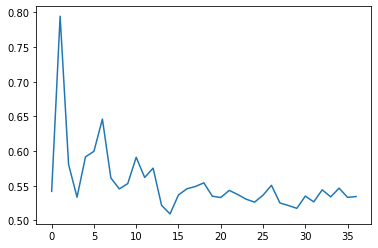

In [192]:
plt.plot([ll['props'] for ll in scores])

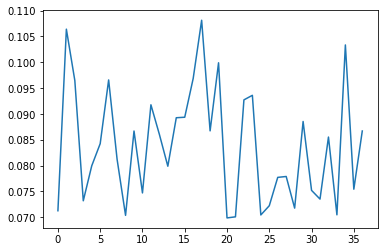

In [194]:
plt.plot([ll['props_mask'] for ll in scores])

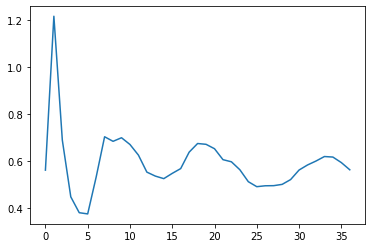

In [195]:
plt.plot([ll['negative'] for ll in scores])

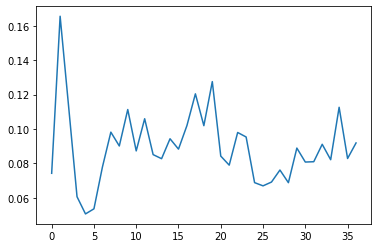

In [196]:
plt.plot([ll['negative_mask'] for ll in scores])

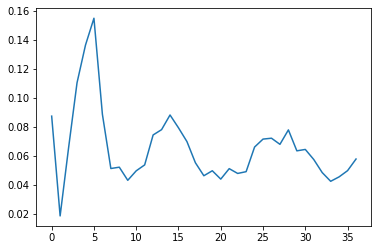

In [197]:
plt.plot([ll['positive_max'] for ll in scores])

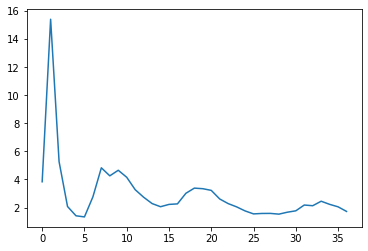

In [198]:
plt.plot([ll['positive_sum'] for ll in scores])

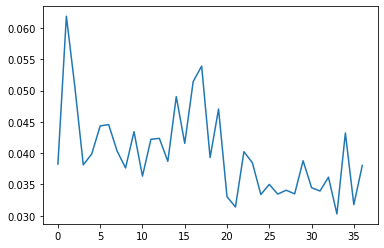

In [199]:
plt.plot([ll['final'] for ll in scores])

In [ ]:
final

### Properties Loss

In [ ]:
np.mean(hist_props[-100:]), np.mean(hist_props_mask[-100:])
# (0.21114865571260452, 0.09845495611429214)

(0.21114865571260452, 0.09845495611429214)

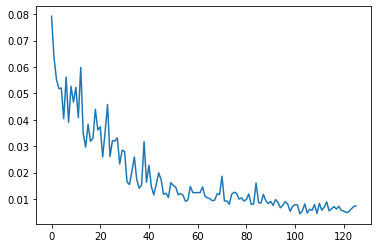

In [216]:
plt.plot(hist_props)

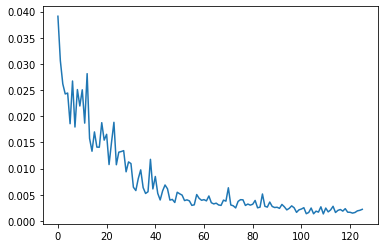

In [217]:
plt.plot(hist_props_mask)

### Negative Loss

In [246]:
np.mean(hist_neg[-100:]), np.mean(hist_neg_mask[-100:])
# (0.20501402899622917, 0.10580503925681115)

(0.20501402899622917, 0.10580503925681115)

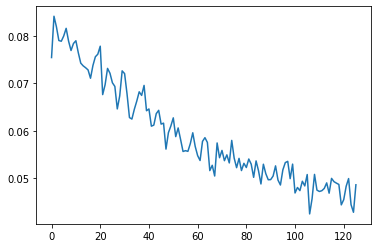

In [219]:
plt.plot(hist_neg)

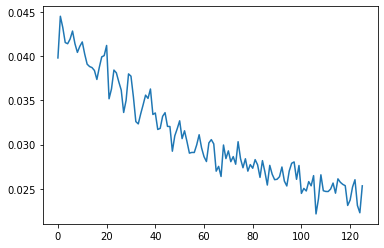

In [220]:
plt.plot(hist_neg_mask)

### Positive Loss Max

In [247]:
np.mean(hist_pos_max[-100:]), np.mean(hist_pos_max_mask[-100:])
# (0.4600797155499458, 0.2261306744813919)

(0.4600797155499458, 0.2261306744813919)

In [230]:
np.exp(-0.0460752572119236)

0.954970091099813

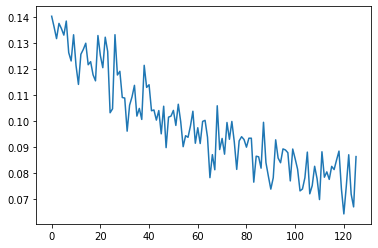

In [222]:
plt.plot(hist_pos_max)

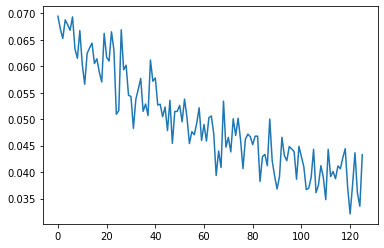

In [223]:
plt.plot(hist_pos_max_mask)

### Positive Loss Sum

In [248]:
np.mean(hist_pos_sum[-100:]), np.mean(hist_pos_sum_mask[-100:])
# (0.8464707934856415, 0.42983739733695986)
# (0.330911158323288, 0.1758657532930374)
# (0.40180815547704696, 0.21392257496714592)
# (3.148419915437698, 1.5483793020248413)

(3.148419915437698, 1.5483793020248413)

In [193]:
np.sqrt(0.4298)

0.6555913361233505

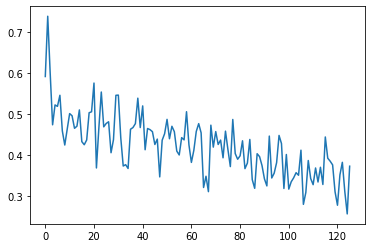

In [225]:
plt.plot(hist_pos_sum)

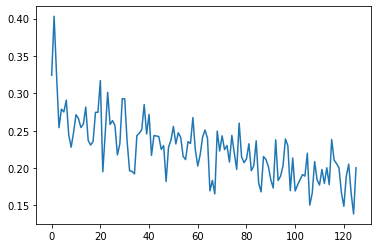

In [226]:
plt.plot(hist_pos_sum_mask)

# Arhitecture

#### Примерный план
1) Каким то образом получаем батч из числовых последовательностей токенов = [Batch_Size, MAX_SEQ_LEN]
2) Определяем конец батча
3) Определяем целевой токен для каждой строки батча
    Получаем следующие данные W0 = [Enc_Pos_0, Token_0], W_Other = [Enc_Pos, Token]
4) Рандомом из батча выбираем где мы будем учитывать 


Рассмотрим на примере одного "предложения".
Предложение -> Tokens -> Seq (Seq_length может быть не равна MAX_SEQ_LEN)
Строим матрицу Seq_Tokens = [Seq] * Seq_length.
Так же берем матрицу расстояний = [MAX_SEQ_LEN, MAX_SEQ_LEN, POS_EMB_SIZE]
Из нее извлекаем подматрицу Seq_Pos = [Seq_length, Seq_length, POS_EMB_SIZE]

Получается две матрицы - Seq_Tokens и Seq_Pos
Выбираем целевое слово, точнее его порядковый номер.
Перемещаем

In [ ]:
0

Можно так же подавать неправильные токены в последовательность, с целью чтоб они все равно предсказывали верные.


In [ ]:
input_seq = [token_0, token_1, token_2, token_3]
all_seq = [
    [token_0, token_1, token_2, token_3],
    [mask, token_1, token_2, token_3],
    [token_0, mask, token_2, token_3],
    [token_0, token_1, mask, token_3],
    [token_0, token_1, token_2, mask],
]

for seq in all_seq:
    seq_emb = []
    mask_pos = get_mask_pos(seq)
    
    
    for token_pos, token in enumerate(seq):
        if token != '[MASK]':
            token_info = []
            pos_emb = get_pos_encoding(token_pos, mask_pos)
            for cat in range(CNT_CATS):
                emb_meanings = get_emb(token, cat) # Cnt_Meanings x Emb_Size
                cat_emb = CATS[cat]
                for m in range(Cnt_Meanings):
                    token_info.append(torch.cat([pos_emb, cat_emb, emb_meaning]))
                    
            token_info = torch.cat(token_info) # Большой тензор, в котором заенкожена вся информация по токену
            seq_emb.append(token_info)
        
    

In [ ]:
pos_encod_matrix = gen_pos_encodind(MAX_LEN_SEQ)
input_seq = [token_0, token_1, token_2, token_3]
seq_emb = []

for token_pos, token in enumerate(seq):
    token_info = []
    pos_emb = get_pos_encoding(token_pos, mask_pos)
    for cat in range(CNT_CATS):
        emb_meanings = get_emb(token, cat) # Cnt_Meanings x Emb_Size
        cat_emb = CATS[cat]
        for m in range(Cnt_Meanings):
            token_info.append(torch.cat([pos_emb, cat_emb, emb_meaning]))

    token_info = torch.cat(token_info) # Большой тензор, в котором заенкожена вся информация по токену
    seq_emb.append(token_info)
    

variant = choose_variant() # Выбираеем вариант

# Кличество вариаций обработки одной последовательности:
# 1) Изменяем какое-либо слова:
#      N вариантов выбрать изменяемое слово в последовательности.
#      N вариантов выбрать целевое слово в последовательности.
#      N^2 вариантов, если мы еще добавим опцию опускать(маскировать) ли целевое слово во время агрегации то 2 * N^2
# 2) Не изменяем слова в последовательности:
#      N вариантов выбрать целевое слово.
#      2 - опускаем или нет целевое слово при аггрегации
#